In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 7557 files belonging to 15 classes.
Using 6046 files for training.
Found 7557 files belonging to 15 classes.
Using 1511 files for validation.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
189/189 [==============================] - 145s 655ms/step - loss: 1.4975 - accuracy: 0.5453 - val_loss: 0.5198 - val_accuracy: 0.8438
Epoch 2/20
189/189 [==============================] - 113s 593ms/step - loss: 0.4451 - accuracy: 0.8660 - val_loss: 0.1844 - val_accuracy: 0.9457
Epoch 3/20
189/189 [==============================] - 112s 589ms/step - loss: 0.1890 - accuracy: 0.9439 - val_loss: 0.1165 - val_accuracy: 0.9676
Epoch 4/20
189/189 [==============================] - 112s 591ms/step - loss: 0.0999 - accuracy: 0.9704 - val_loss: 0.0690 - val_accuracy: 0.9749
Epoch 5/20
189/189 [==============================] - 112s 589ms/step - loss: 0.0812 - accuracy: 0.9787 - val_loss: 0.0627 - val_accuracy: 0.9795
Epoch 6/20
189/189 [==============================] - 112

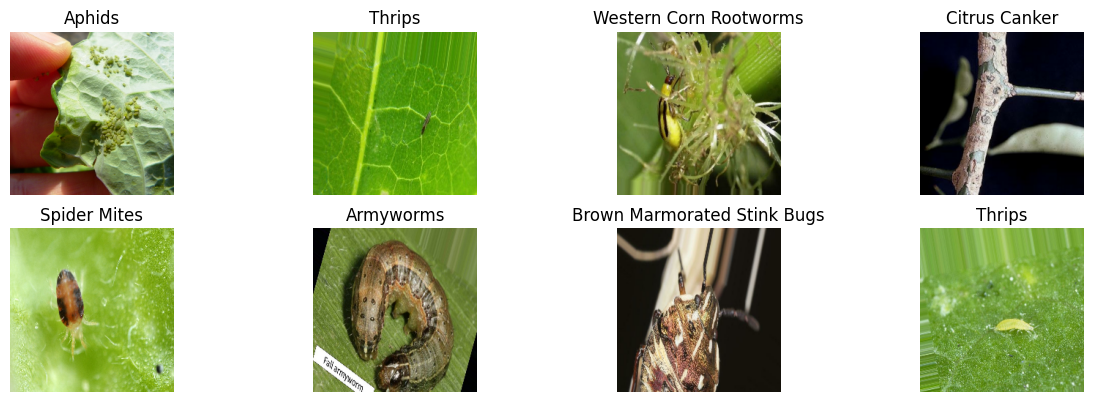

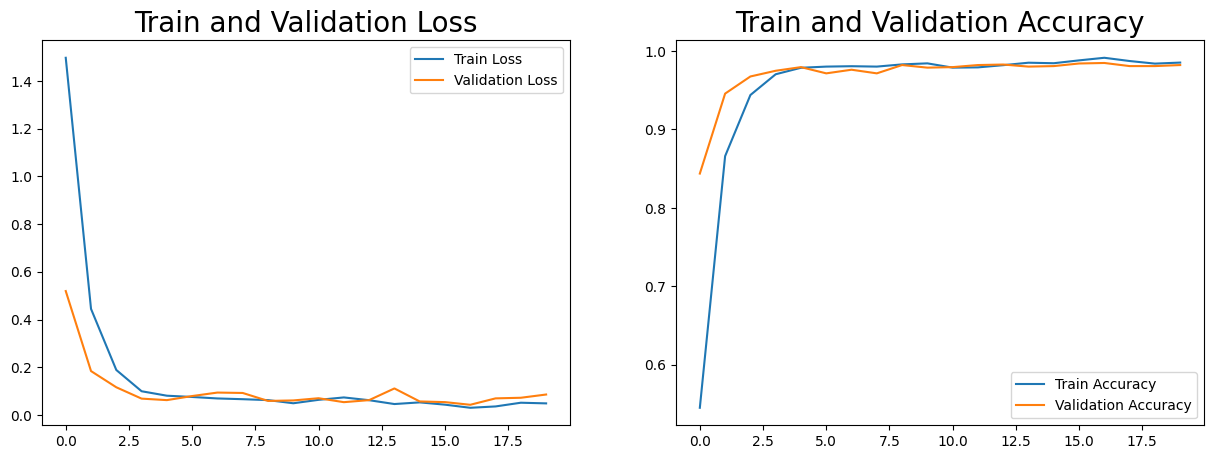

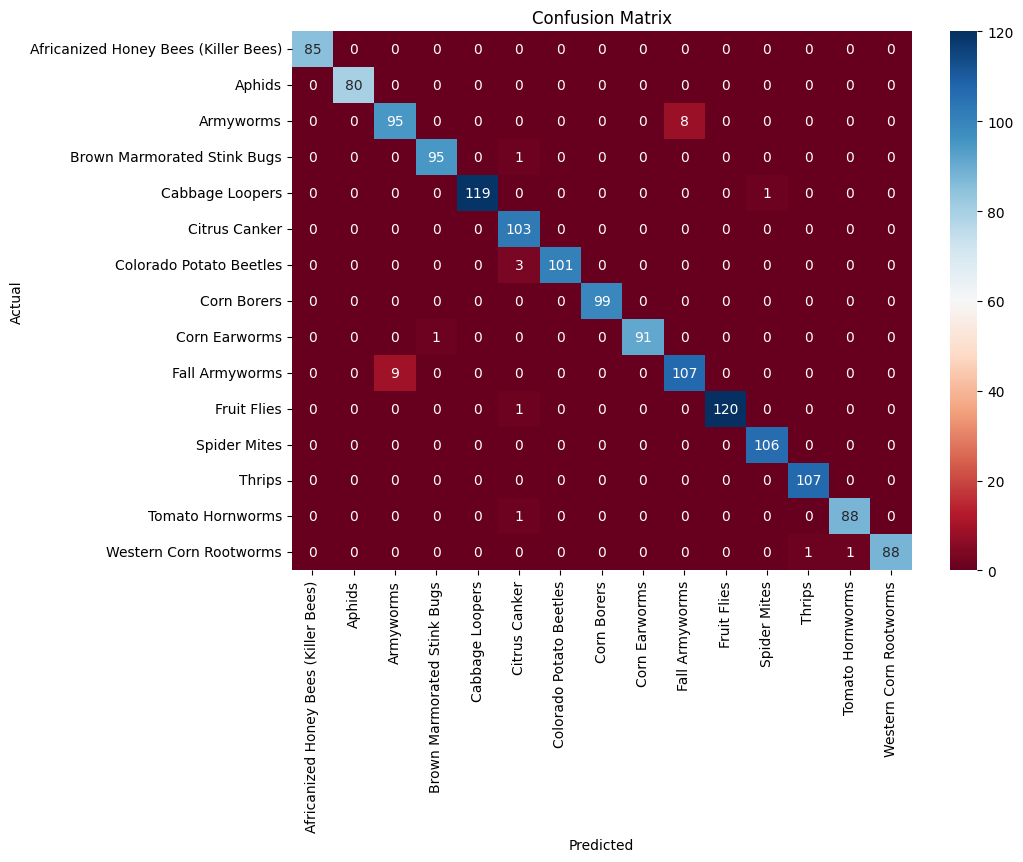

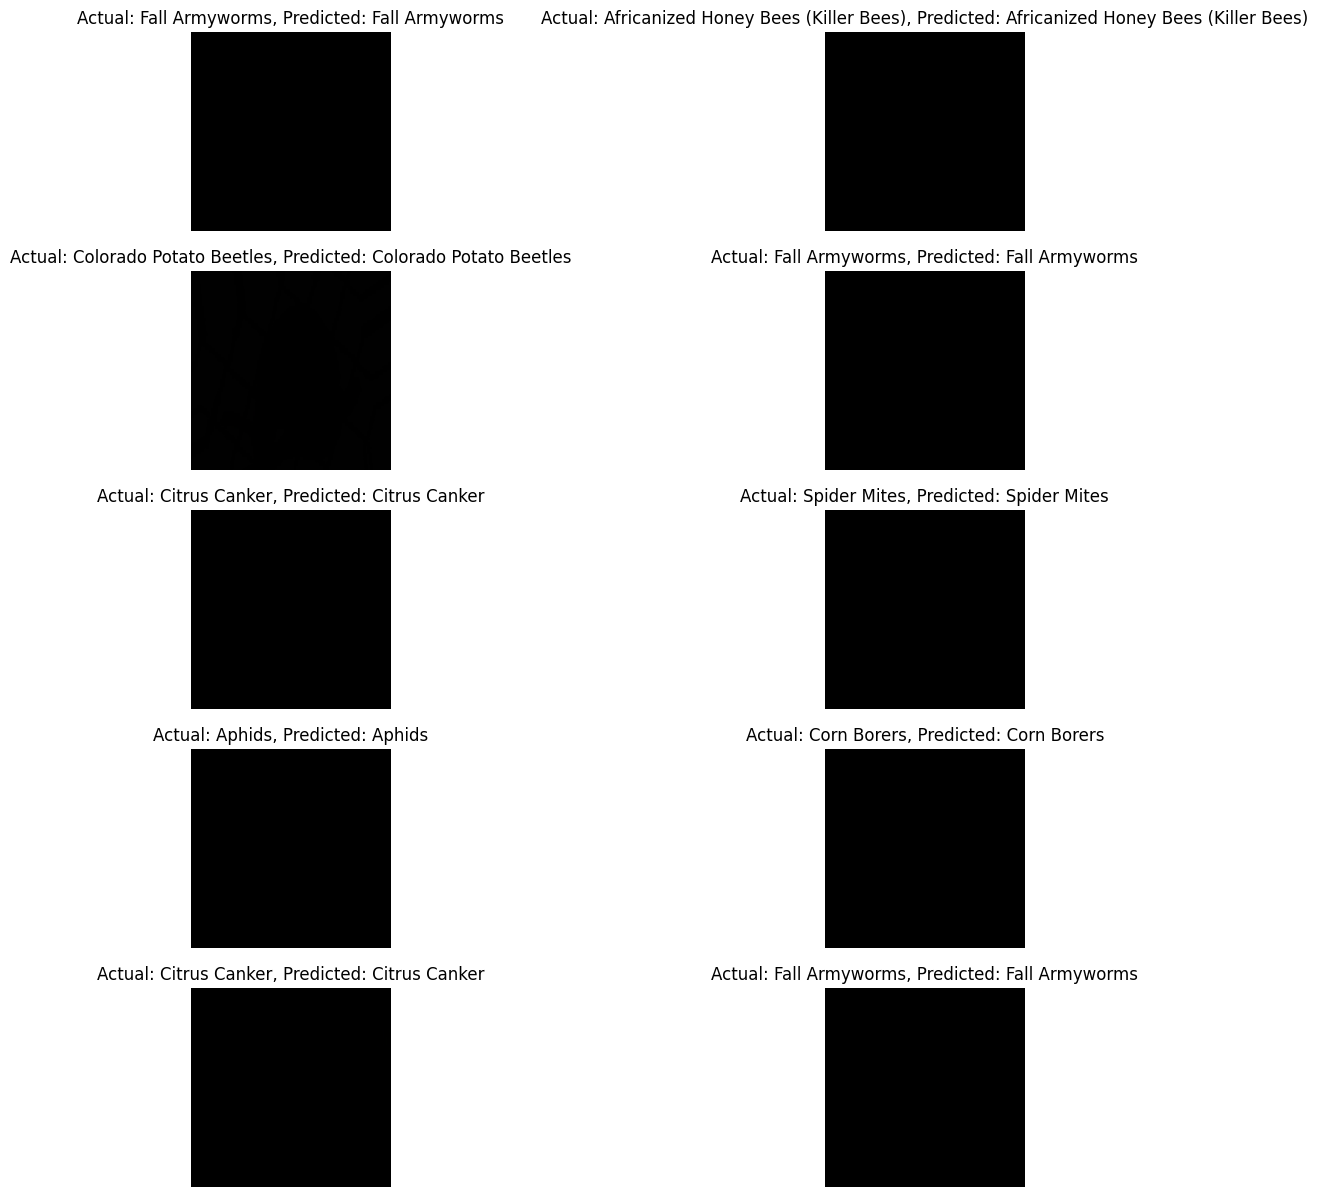

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


image_data = '/content/drive/MyDrive/farm_insects_aug/farm_insects'
batch_size = 32
target_size = (224, 224)
validation_split = 0.2


train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="training",
    seed=100, 
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True  
)

validation_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True 
)


class_names = train_raw.class_names


def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


train = train_raw.map(preprocess)
validation = validation_raw.map(preprocess)


def duplicate_inputs(image, label):
    return (image, image), label


train = train.map(duplicate_inputs)
validation = validation.map(duplicate_inputs)


plt.figure(figsize=(15, 20))
for images, labels in train_raw.take(1):  
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


mobilenetv3_base = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
inceptionv3_base = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


mobilenetv3_base.trainable = True
inceptionv3_base.trainable = True


for layer in mobilenetv3_base.layers[:100]:
    layer.trainable = False
for layer in inceptionv3_base.layers[:100]:
    layer.trainable = False


mobilenetv3_output = mobilenetv3_base.output
mobilenetv3_output = layers.GlobalAveragePooling2D()(mobilenetv3_output)

inceptionv3_output = inceptionv3_base.output
inceptionv3_output = layers.GlobalAveragePooling2D()(inceptionv3_output)


concatenated_features = layers.Concatenate()([mobilenetv3_output, inceptionv3_output])


x = layers.Dense(128, activation='relu')(concatenated_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)


hybrid_model = keras.models.Model(inputs=[mobilenetv3_base.input, inceptionv3_base.input], outputs=output)


hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


y_train = np.concatenate([y for x, y in train_raw], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hist = hybrid_model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[early_stopping],
    class_weight=class_weights
)


hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy', fontsize=20)
plt.legend()


X_val, y_val, y_pred = [], [], []
for (img1, img2), labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(img1.numpy()) 

predictions = hybrid_model.predict([np.array(X_val), np.array(X_val)])
y_pred = [np.argmax(i) for i in predictions]


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='RdBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


import random
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(X_val[idx].astype("uint8"))
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()

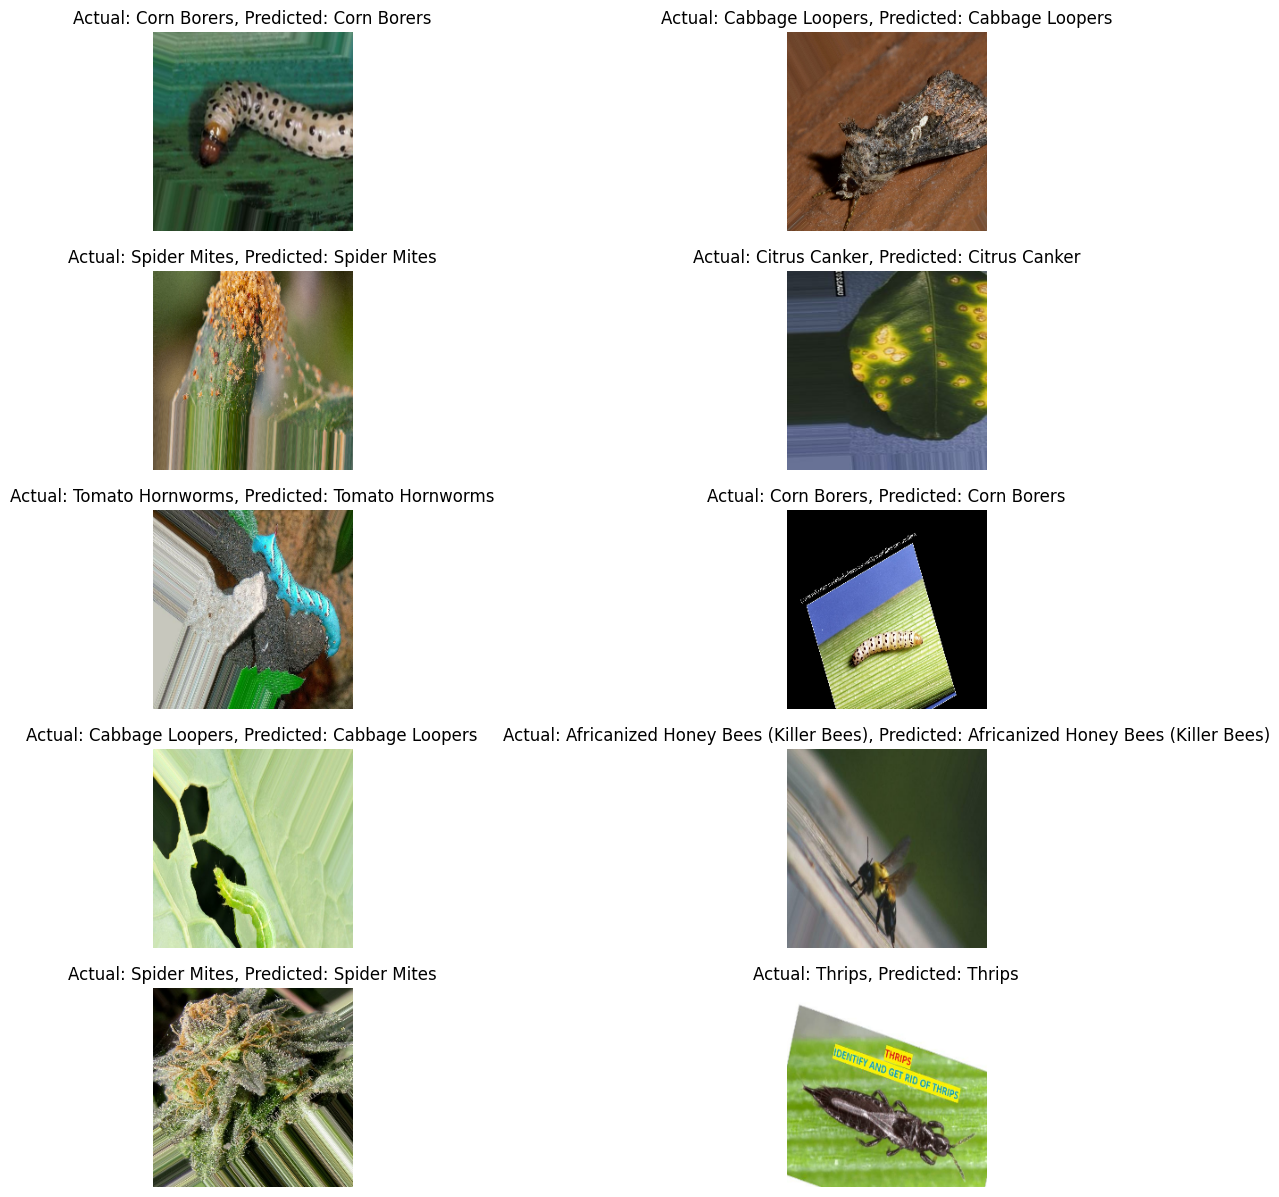

In [3]:
# Display some sample validation images with predicted and actual labels
import random
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow((X_val[idx] * 255).astype("uint8"))  # Ensure images are in color by scaling back to 0-255
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()



In [4]:
# Save the model in HDF5 format
model_path = '/content/drive/MyDrive/your_model_name.h5'
hybrid_model.save(model_path)

print(f"Model saved at {model_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at /content/drive/MyDrive/your_model_name.h5
